In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, CuDNNLSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
# extract data after processing
MSFT = pd.read_csv('MSFT.csv')
BILI = pd.read_csv('BILI.csv')
AAPL = pd.read_csv('AAPL.csv')
TWTR = pd.read_csv('TWTR.csv')
UBER = pd.read_csv('UBER.csv')
TSLA = pd.read_csv('TSLA.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# **Purpose here: make our data into the form that can be feeded into the neural network**

In [ ]:
# Purpose here: make our data into the form that can be feeded into the neural network

######### PART ONE : Some Auxiliary Function ##############
# a function to transform X and Y into rolling window of length 'T'
def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T : N]
    dataX = np.zeros((N - T, T, D))
    for i in range(T, N):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

# a function that will be used in the next 'normalizaiton_zscore' function
def rolling_window(a, window):
  shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
  strides = a.strides + (a.strides[-1],)
  return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#  a function that standardize data into z-score by the method of rolling window
def normalization_zscore(arr, window):
  arr=arr.T
  mean = np.mean(rolling_window(arr,window),-1)
  std = np.mean(rolling_window(arr,window),-1)
  arr1=arr[:,(window-1):]
  return ((arr1-mean)/std).T


######### PART TWO: Main Function for Data Preparation ##############

def prepare_x_y(df, stock, k, T, alpha=1e-05, normalization_window=5):

  # 'df' is the input data
  # 'stock' is the number code of the stock (e.g. 'MSFT' is '1')
  # 'k' is prediction horizon
  # 'T' is the length of a single input
  # 'alpha' is threshold of going up or down

  X = (df[df['Stock']==stock].iloc[:, 3:]).copy()
  list_columns=['PRICE_ASK_0','VOLUME_ASK_0','PRICE_BID_0','VOLUME_BID_0',
                'PRICE_ASK_1','VOLUME_ASK_1','PRICE_BID_1','VOLUME_BID_1',
                'PRICE_ASK_2','VOLUME_ASK_2','PRICE_BID_2','VOLUME_BID_2',
                'PRICE_ASK_3','VOLUME_ASK_3','PRICE_BID_3','VOLUME_BID_3',
                'PRICE_ASK_4','VOLUME_ASK_4','PRICE_BID_4','VOLUME_BID_4',
                'PRICE_ASK_5','VOLUME_ASK_5','PRICE_BID_5','VOLUME_BID_5',
                'PRICE_ASK_6','VOLUME_ASK_6','PRICE_BID_6','VOLUME_BID_6',
                'PRICE_ASK_7','VOLUME_ASK_7','PRICE_BID_7','VOLUME_BID_7',
                'PRICE_ASK_8','VOLUME_ASK_8','PRICE_BID_8','VOLUME_BID_8',
                'PRICE_ASK_9','VOLUME_ASK_9','PRICE_BID_9','VOLUME_BID_9']
  # only extract the columns listed above
  X=X[list_columns]
  X=X.reset_index(drop=True)

  # calculate the mid price of stock
  mid=(X['PRICE_ASK_0']+X['PRICE_BID_0'])/2
  
  # Here we smooth our data to label the price movement
  # m_minus is the mean of the previous k mid-price
  m_minus=mid.rolling(window = k).mean()
  for i in range(k-1):
    m_minus[i]=mid[:(i+1)].mean()
  
  # m_plus is the mean of the next k mid-price
  m_plus=m_minus.copy()
  m_plus[:(len(X)-k)]=m_plus[k:]
  for i in range(k):
    m_plus[len(X)-k+i]=mid[(len(X)-k+i):].mean()
  
  # l is the percentage change of smoothed mid-price
  l=(m_plus-m_minus)/m_minus
  Y=l.copy()
  Y[l<=-alpha] = 0  # stock price is going to decrease (red)
  Y[(l>-alpha)&(l<=alpha)] = 1  # stock price is going to be steady (white)
  Y[l>alpha] = 2  # stock price is going to increase (green)
  
  # Conduct the rolling normalize of X after labelling
  X=pd.DataFrame(normalization_zscore(np.array(X), normalization_window),columns=list_columns)

  # transform X and Y into rolling window of length 'T'
  X, Y = data_classification(X, Y, T=T)

  # change Y to the form of one-hot coding
  Y = np_utils.to_categorical(Y, 3)
  
  return mid, X, Y

In [ ]:
# prediction horizon k = 10, rolling window length = 100, threshold = 1e-4, normalizaiton window = 10 (unit: timepoint)
mid_msft, X_msft, Y_msft = prepare_x_y(df = MSFT, stock = 1, k=10, T=100, alpha=1e-4, normalization_window = 10)
mid_bili, X_bili, Y_bili = prepare_x_y(df = BILI, stock = 2, k=10, T=100, alpha=1e-4, normalization_window = 10)
mid_aapl, X_aapl, Y_aapl = prepare_x_y(df = AAPL, stock = 3, k=10, T=100, alpha=1e-4, normalization_window = 10)
mid_twtr, X_twtr, Y_twtr = prepare_x_y(df = TWTR, stock = 1, k=10, T=100, alpha=1e-4, normalization_window = 10)
mid_uber, X_uber, Y_uber = prepare_x_y(df = UBER, stock = 2, k=10, T=100, alpha=1e-4, normalization_window = 10)
mid_tsla, X_tsla, Y_tsla = prepare_x_y(df = TSLA, stock = 3, k=10, T=100, alpha=1e-4, normalization_window = 10)

# **FIRST: Visulization the Mid Price of our Processed Data and Make Comparison**

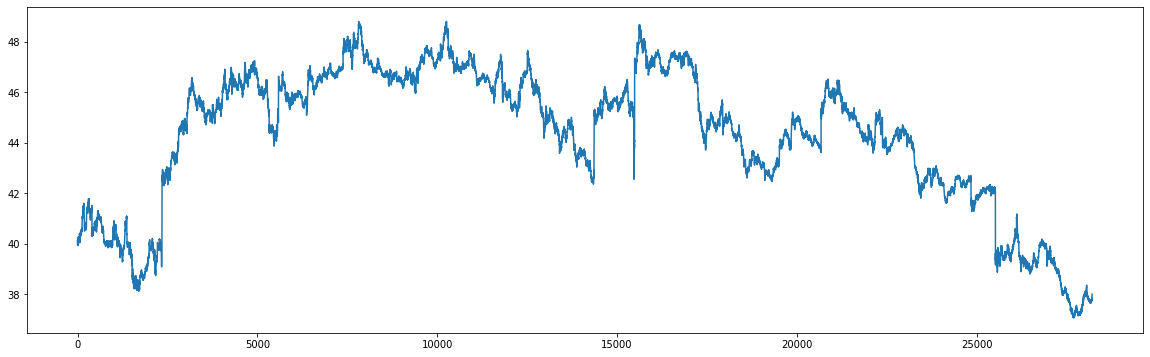

In [ ]:
# plot the mid price of UBER
plt.figure(figsize = (20,6))
plt.plot(mid_uber)

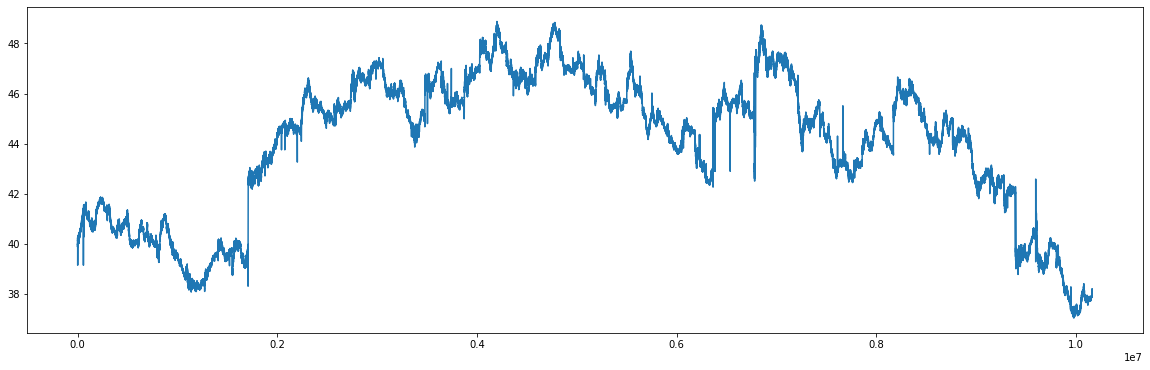

In [ ]:
# 'unbertrade' is the data downloaded from WRDS-TAQ-TRADE, which samples only the real happened trade
ubertrade = pd.read_csv('ubertrade.csv')
plt.figure(figsize = (20, 6))
plt.plot(ubertrade['PRICE'])

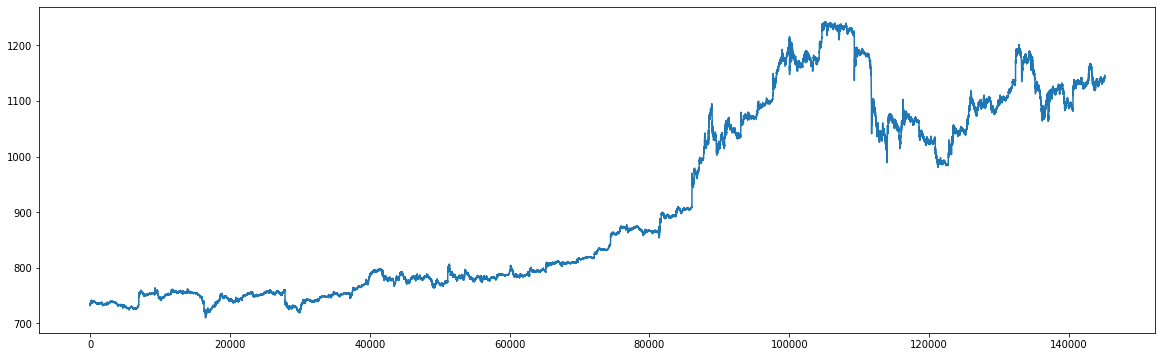

In [ ]:
# plot the mid price of UBER
plt.figure(figsize = (20,6))
plt.plot(mid_tsla)

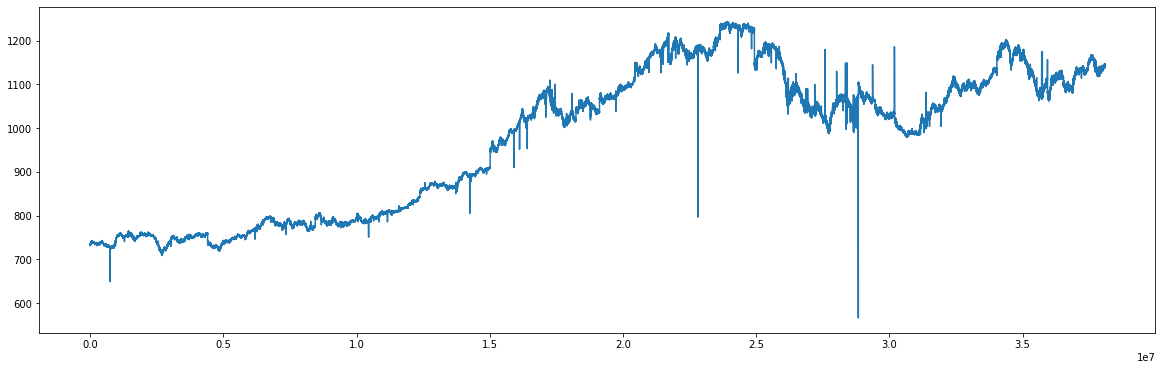

In [ ]:
# 'tslatrade' is the data downloaded from WRDS-TAQ-TRADE, which samples only the real happened trade
tslatrade = pd.read_csv('tslatrade.csv')
plt.figure(figsize = (20,6))
plt.plot(tslatrade['PRICE'])

# **PART TWO: Visulization of our Label Result for Different Prediction Horizon**

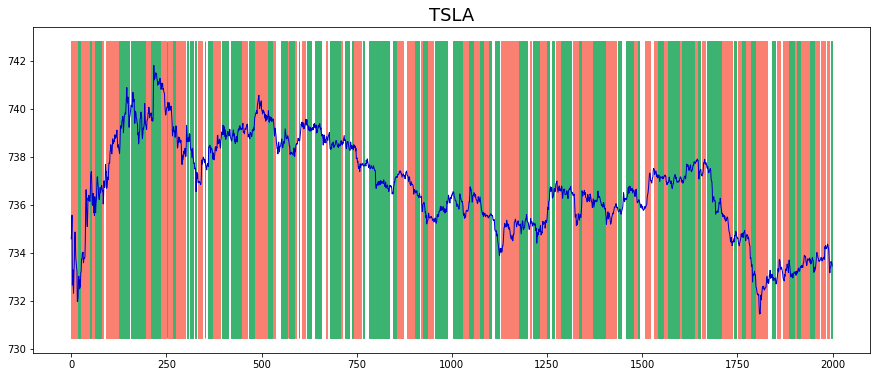

In [ ]:
# preidiction horizon k = 10
x = np.arange(len(mid_tsla[:2000]))

fig = plt.figure(figsize=(15, 6))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(mid_tsla[:2000], lw = 1, color = 'mediumblue')
ax.set_title('TSLA', fontsize = 18)
ax.fill_between(x, np.min(mid_tsla[:2000])-1, np.max(mid_tsla[:2000])+1, where = (np.argmax(Y_tsla[:2000], axis = 1) == 2), color = 'salmon')
ax.fill_between(x, np.min(mid_tsla[:2000])-1, np.max(mid_tsla[:2000])+1, where = (np.argmax(Y_tsla[:2000], axis = 1) == 0), color = 'mediumseagreen')
plt.show()

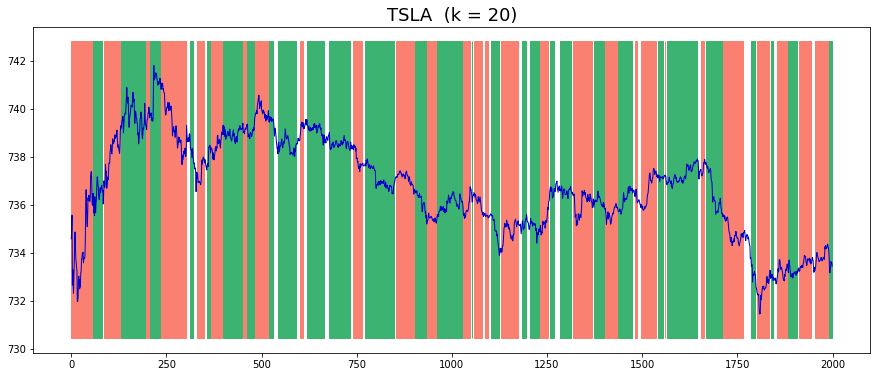

In [ ]:
# preidiction horizon k = 20
x = np.arange(len(mid_tsla[:2000]))

fig = plt.figure(figsize=(15, 6))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(mid_tsla[:2000], lw = 1, color = 'mediumblue')
ax.set_title('TSLA  (k = 20)', fontsize = 18)
ax.fill_between(x, np.min(mid_tsla[:2000])-1, np.max(mid_tsla[:2000])+1, where = (np.argmax(Y_tsla[:2000], axis = 1) == 2), color = 'salmon')
ax.fill_between(x, np.min(mid_tsla[:2000])-1, np.max(mid_tsla[:2000])+1, where = (np.argmax(Y_tsla[:2000], axis = 1) == 0), color = 'mediumseagreen')
plt.show()

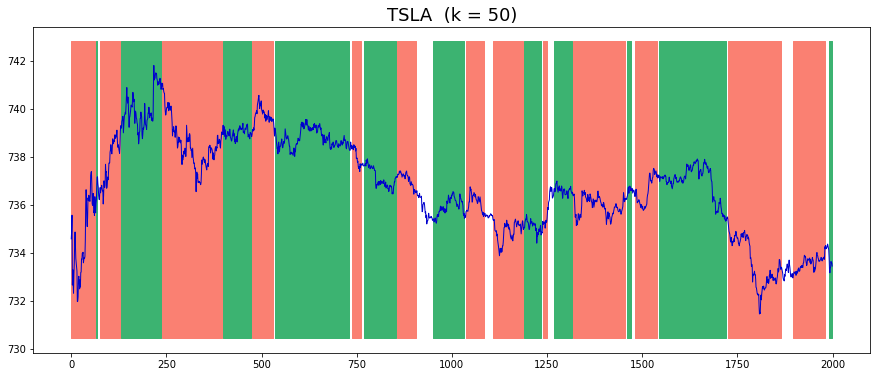

In [ ]:
# preidiction horizon k = 50
x = np.arange(len(mid_tsla[:2000]))

fig = plt.figure(figsize=(15, 6))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(mid_tsla[:2000], lw = 1, color = 'mediumblue')
ax.set_title('TSLA  (k = 50)', fontsize = 18)
ax.fill_between(x, np.min(mid_tsla[:2000])-1, np.max(mid_tsla[:2000])+1, where = (np.argmax(Y_tsla[:2000], axis = 1) == 2), color = 'salmon')
ax.fill_between(x, np.min(mid_tsla[:2000])-1, np.max(mid_tsla[:2000])+1, where = (np.argmax(Y_tsla[:2000], axis = 1) == 0), color = 'mediumseagreen')
plt.show()